# <center><b> Intelligent News Summarization and Analysis </b></center>

## Importing Packages

In [1]:
import requests # for HTTP requests
import time # for time-related functions
import json # for JSON handling

import re # for regular expressions
from bs4 import BeautifulSoup # for web scraping

import boto3 # for AWS interactions
from botocore.exceptions import ClientError # for handling AWS errors

import numpy as np # for numerical computations
import pandas as pd # for savig csv and dataframe operations

from sklearn.feature_extraction.text import TfidfVectorizer # for converting text data into numerical features using TF-IDF
from sklearn.cluster import KMeans # for performing K-means clustering on data
from sklearn.decomposition import PCA # for dimensionality reduction using Principal Component Analysis
import matplotlib.pyplot as plt # for creating static, animated, and interactive visualizations
from collections import defaultdict # for creating dictionaries with default values
from datetime import datetime # for working with dates and times
import matplotlib.dates as mdates # for handling date formatting in matplotlib visualizations

In [2]:
from dotenv import load_dotenv
import os

### Load environment variables from .env file


In [3]:
load_dotenv()

# Access the API keys
api_key = os.getenv('API_KEY')

## Data Collection (API Integration)

In [4]:
class NewsFetcher:
    """
    A class to fetch news articles from the NewsAPI.

    This class provides a way to interact with the NewsAPI (https://newsapi.org/),
    allowing users to search for news articles based on a query. It handles HTTP requests,
    error handling, and manages issues like rate limits by retrying requests when needed.

    Attributes:
        api_key (str): The API key used to authenticate with the NewsAPI.
        base_url (str): The base URL for the NewsAPI endpoint. Defaults to the "everything" endpoint.

    Methods:
        __init__(self, api_key, base_url="https://newsapi.org/v2/everything"):
            Initializes the NewsFetcher object with an API key and optional base URL.
        
        fetch_news(self, query, page=1, page_size=10):
            Fetches a list of news articles based on the given query, page number, and page size.
            Handles errors such as HTTP issues and rate limits. Returns a list of articles or an empty list.
    """
    def __init__(self, api_key, base_url="https://newsapi.org/v2/everything"):
        self.api_key = api_key
        self.base_url = base_url

    def fetch_news(self, query, page=1, page_size=10):
        url = f"{self.base_url}?q={query}&pageSize={page_size}&page={page}&apiKey={self.api_key}"
        try:
            response = requests.get(url)
            response.raise_for_status()
            data = response.json()
            if data['status'] == 'ok':
                return data['articles']
            else:
                print("Error fetching news:", data.get('message'))
        except requests.exceptions.RequestException as e:
            print(f"An error occurred: {e}")
        except requests.exceptions.HTTPError as err:
            print("HTTP error:", err)
            # Handle rate limit - retry after delay if needed
            if err.response.status_code == 429:
                time.sleep(60)  # Wait 60 seconds as an example
                return self.fetch_news(query, page, page_size)
        return []


### Article Processing


In [5]:
import warnings
from bs4 import MarkupResemblesLocatorWarning
warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)

In [6]:
class ArticleProcessor:
    """
    A class for processing and cleaning news articles.

    This class provides utility methods to clean the content of news articles by
    removing HTML tags, special characters, and extra spaces. It also processes 
    a list of articles, extracting key information such as title, date, content, 
    and source.

    Methods:
        clean_text(text):
            Cleans the provided text by removing HTML tags, special characters, 
            converting to lowercase, and removing extra spaces.
        
        process_articles(articles):
            Processes a list of articles, extracting and cleaning key information
            like title, publication date, content, and source name.
    """
    @staticmethod
    def clean_text(text):
        # Remove HTML tags
        text = BeautifulSoup(text, "html.parser").get_text()
        # Remove special characters
        text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
        # Convert to lowercase
        text = text.lower()
        # Remove extra spaces
        text = re.sub(r"\s+", " ", text).strip()
        return text

    @staticmethod
    def process_articles(articles):
        processed = []
        for article in articles:
            processed.append({
                'title': article.get('title'),
                'date': article.get('publishedAt'),
                'content': ArticleProcessor.clean_text(article.get('content', "")),
                'source': article.get('source', {}).get('name')
            })
        return processed


## LLM Integration

In [7]:
class LLMProcessor:
    def __init__(self, region="us-west-2", model_id="anthropic.claude-3-sonnet-20240229-v1:0"):
        self.client = boto3.client("bedrock-runtime", region_name=region)
        self.model_id = model_id

    def process_article(self, article):
        content = article['content']
        
        prompts = {
            "summary": (
                f"Please provide a concise and informative summary of the following article. "
                f"Focus on capturing the main points, key events, and conclusions:\n{content}"
            ),
            "key_points": (
                f"Extract the key points from the following article. "
                f"Focus on major events, important figures, and any notable outcomes. "
                f"List each key point as a separate item for clarity:\n{content}"
            ),
            "sentiment": (
                f"Analyze the overall sentiment of the following article, rating it as positive, neutral, or negative, "
                f"and provide a sentiment score between -1 (very negative) and 1 (very positive):\n{content}"
            ),
            "topic_classification": (
                f"Based on the content provided, classify the primary topic of the article into a broad category, "
                f"such as politics, technology, sports, health, entertainment, etc. Provide a brief explanation "
                f"for why this category is appropriate:\n{content}"
            )
        }
        
        results = {task: self._call_claude(prompt) for task, prompt in prompts.items()}
        
        # Extract sentiment score from the sentiment response using regex
        sentiment_score = self._extract_sentiment_score(results["sentiment"])
        sentiment_label = results["sentiment"].split()[0]  # Extract sentiment label

        return {
            "title": article.get("title"),
            "date": article.get("date"),
            "source": article.get("source"),
            "content": content,
            "summary": results["summary"],
            "key_points": results["key_points"].split("\n"),
            "sentiment": sentiment_label,
            "sentiment_score": sentiment_score,
            "topic": results["topic_classification"]
        }

    def _extract_sentiment_score(self, sentiment_text):
        """
        Extracts sentiment score from sentiment text using regex. Assumes sentiment score is
        given as a number between -1 and 1 in the model's response.
        """
        match = re.search(r"(-?\d+\.\d+)", sentiment_text)
        return float(match.group(0)) if match else 0.0  # Default to 0.0 if no score found

    def _call_claude(self, prompt, max_retries=3, wait_time=10):
        conversation = [
            {
                "role": "user",
                "content": [{"text": prompt}],
            }
        ]
        
        for attempt in range(max_retries):
            try:
                response = self.client.converse(
                    modelId=self.model_id,
                    messages=conversation,
                    inferenceConfig={"maxTokens": 4096, "temperature": 0},
                    additionalModelRequestFields={"top_k": 250}
                )
                
                return response["output"]["message"]["content"][0]["text"]
            
            except ClientError as e:
                print(f"ERROR: Unable to invoke model '{self.model_id}'. Reason: {e}")
                if attempt == max_retries - 1:
                    return "Request failed after retries."
                time.sleep(wait_time)
            except Exception as e:
                print(f"Unexpected error: {e}")
                if attempt == max_retries - 1:
                    return "Request failed due to an unexpected error."
                time.sleep(wait_time)
        
        return "Request failed after retries."


## Analysis and Insights

In [8]:
class InsightsAnalyzer:
    def __init__(self, n_clusters=5):
        # Initialize TF-IDF vectorizer and KMeans clustering
        self.vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
        self.n_clusters = n_clusters
        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=0)

    def cluster_topics(self, articles):
        """
        Clusters topics based on article content using TF-IDF and KMeans.
        Returns a list of cluster labels corresponding to each article.
        """
        contents = [article['content'] for article in articles]
        X = self.vectorizer.fit_transform(contents)
        self.kmeans.fit(X)
        clusters = self.kmeans.predict(X)
        return clusters

    def visualize_clusters(self, articles):
        """
        Visualizes clusters using PCA for dimensionality reduction.
        """
        contents = [article['content'] for article in articles]
        X = self.vectorizer.fit_transform(contents)
        reduced_data = PCA(n_components=2).fit_transform(X.toarray())
        clusters = self.kmeans.predict(X)

        plt.figure(figsize=(10, 6))
        scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis')
        plt.title("Article Topic Clusters")
        plt.xlabel("PCA Component 1")
        plt.ylabel("PCA Component 2")
        plt.legend(handles=scatter.legend_elements()[0], labels=list(range(self.n_clusters)))
        plt.show()

    def trend_analysis(self, articles, keywords=None):
        """
        Analyzes trends in article data over time by counting occurrences of specific keywords
        or article counts per date.
        """
        trend_data = defaultdict(int)
        
        if keywords:
            for article in articles:
                # Skip articles with missing dates or content
                date = article.get('date')
                content = article.get('content')
                
                if date is None or content is None:
                    continue  # Skip this article if date or content is None
    
                # Extract date in 'YYYY-MM-DD' format
                date = date[:10]
                
                # Count occurrences of keywords
                for keyword in keywords:
                    if keyword.lower() in content.lower():
                        trend_data[date] += 1
        else:
            for article in articles:
                date = article.get('date')
                if date is None:
                    continue  # Skip this article if date is None
    
                # Extract date in 'YYYY-MM-DD' format
                date = date[:10]
                trend_data[date] += 1
        
        trend_data = dict(sorted(trend_data.items()))
        return trend_data


    def plot_trend_analysis(self, trend_data):
        """
        Plots the trend data over time.
        """
        dates = [datetime.strptime(date, "%Y-%m-%d") for date in trend_data.keys()]
        counts = list(trend_data.values())
        
        plt.figure(figsize=(10, 6))
        plt.plot(dates, counts, marker='o')
        plt.title("Article Trend Analysis Over Time")
        plt.xlabel("Date")
        plt.ylabel("Count of Articles / Mentions")
        plt.grid(True)
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
        plt.gcf().autofmt_xdate()
        plt.show()

    def sentiment_trend_analysis(self, articles, sentiment_scores):
        """
        Tracks sentiment over time by associating dates with average sentiment scores.
        """
        sentiment_data = defaultdict(list)
        
        # Ensure that articles and sentiment_scores have the same length
        if len(articles) != len(sentiment_scores):
            raise ValueError("The length of articles and sentiment_scores must be the same.")
    
        for article, sentiment in zip(articles, sentiment_scores):
            # Check if the article is not None
            if article is None:
                continue  # Skip this iteration if article is None
                
            date = article.get('date')
            if date is None:  # Check if date is None
                continue  # Skip this article if date is None
                
            # Extract date in 'YYYY-MM-DD' format
            date = date[:10]
            sentiment_data[date].append(sentiment)
        
        avg_sentiment_data = {date: np.mean(scores) for date, scores in sentiment_data.items()}
        avg_sentiment_data = dict(sorted(avg_sentiment_data.items()))
        return avg_sentiment_data


    def plot_sentiment_trend(self, sentiment_data):
        """
        Plots average sentiment over time.
        """
        dates = [datetime.strptime(date, "%Y-%m-%d") for date in sentiment_data.keys()]
        avg_sentiments = list(sentiment_data.values())
        
        plt.figure(figsize=(10, 6))
        plt.plot(dates, avg_sentiments, marker='o', color='b')
        plt.title("Sentiment Trend Over Time")
        plt.xlabel("Date")
        plt.ylabel("Average Sentiment Score")
        plt.grid(True)
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
        plt.gcf().autofmt_xdate()
        plt.show()


from wordcloud import WordCloud

def plt_wordcloud(processed_articles):
    # Assuming processed_articles["articles"] is already defined and contains articles
    text_data = " ".join(article["content"] for article in processed_articles["articles"])
    
    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)
    
    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Hide the axes
    plt.show()


## Integrating Pipeline to RUN


Data Collection and Preprocessing:

- Use `NewsFetcher` to collect articles and `ArticleProcessor` to clean and extract necessary fields from each article.

In [9]:
fetcher = NewsFetcher(api_key)
articles = fetcher.fetch_news("technology", page=1, page_size=5)
processed_articles = ArticleProcessor.process_articles(articles)

LLM Processing for Sentiment Analysis:
- Use `LLMProcessor` to analyze sentiment for each article.

In [10]:
llm_processor = LLMProcessor(region="us-west-2", model_id="anthropic.claude-3-sonnet-20240229-v1:0")
processed_articles = {"articles": [llm_processor.process_article(article) for article in articles]}
sentiment_scores = [article["sentiment_score"] for article in processed_articles["articles"]]


Print and Analyze Data

In [11]:
print(json.dumps(processed_articles, indent=2))

{
  "articles": [
    {
      "title": "How Researchers Are Using Geospatial Technology to Uncover Mexico's Clandestine Graves",
      "date": null,
      "source": {
        "id": "wired",
        "name": "Wired"
      },
      "content": "In 2014, after the disappearance of 43 Ayotzinapa normalistas in Mexico, Silv\u00e1n and other CentroGeo professionals joined the scientific advisory board on the case. During the search for the students,\u2026 [+2586 chars]",
      "summary": "Here is a concise summary of the key points from the article:\n\nThe article discusses the disappearance of 43 students from the Ayotzinapa teachers' college in Mexico in 2014. After their disappearance, a group of professionals from CentroGeo, including Silv\u00e1n, joined the scientific advisory board investigating the case. \n\nDuring the search efforts, CentroGeo used remote sensing data and analysis to identify possible clandestine graves and provide insights into the movements of the students based on c

In [12]:
df = pd.json_normalize(processed_articles["articles"])

print("DataFrame representation of processed articles:")
df.head()


DataFrame representation of processed articles:


,title,date,content,summary,key_points,sentiment,sentiment_score,topic,source.id,source.name
0,How Researchers Are Using Geospatial Technolog...,None,"In 2014, after the disappearance of 43 Ayotzin...",Here is a concise summary of the key points fr...,"[Here are the key points from the article:, , ...",To,0.2,"Based on the content provided, the primary top...",wired,Wired
1,What Are Hall Effect Sensors and How Do They W...,None,Hall effect sensors are everywhere right now. ...,Here is a concise summary of the key points fr...,"[Here are the key points from the article:, , ...",To,0.0,"Based on the content provided, the primary top...",wired,Wired
2,Sonos announces ‘breakthrough’ Arc Ultra sound...,None,Sonos announces breakthrough Arc Ultra soundba...,Here is a concise summary of the article:\n\nS...,"[Here are the key points from the article:, , ...",Based,0.7,"Based on the content provided, the primary top...",the-verge,The Verge
3,"Back to Its Prime Day Price (59% Off), The Rob...",None,The Roborock Q7 Max+ robot vacuum cleaner is c...,Here is a concise summary of the key points fr...,"[Unfortunately, the provided text does not app...",To,0.9,"Based on the content provided, the primary top...",None,Gizmodo.com
4,It Seemed Like an AI Crime-Fighting Super Tool...,None,"In 2017, then 9-year-old Kayla Unbehaun was ab...",Here is a concise summary of the key points fr...,"[Here are the key points from the article:, , ...",Based,-0.2,"Based on the content provided, the primary top...",wired,Wired


### Saving Data

In [13]:
# Save DataFrame to CSV
df.to_csv("OUTPUTprocessed_articles.csv", index=False)

# Save DataFrame to JSON
df.to_json("OUTPUTprocessed_articles.json", orient="records", indent=2)

print("\nData saved to 'processed_articles.csv' and 'processed_articles.json'")


Data saved to 'processed_articles.csv' and 'processed_articles.json'


Insights and Visualization:
- Passing `processed_articles` and `sentiment_scores` to `InsightsAnalyzer` for further analysis.

In [14]:
# Initialize InsightsAnalyzer and perform clustering
analyzer = InsightsAnalyzer(n_clusters=3)
clusters = analyzer.cluster_topics(processed_articles["articles"])  # Pass the list of articles

print("Cluster labels for each article:", clusters)


Cluster labels for each article: [2 2 0 1 2]


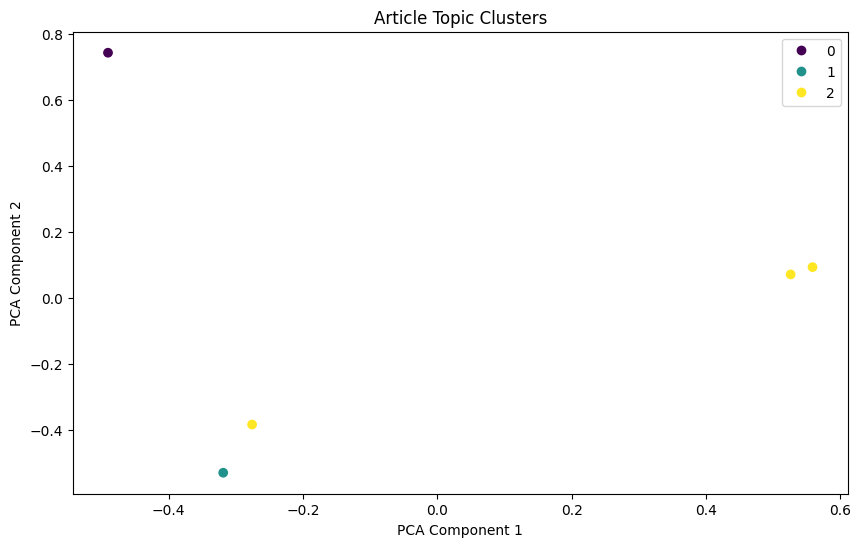

In [15]:
# Visualize clusters
analyzer.visualize_clusters(processed_articles["articles"])


Cluster Separation: The clusters appear to be well-separated, indicating that the clustering algorithm has successfully identified distinct groups of articles with similar topics.

Cluster Size: Cluster 0 (purple) has the smallest number of articles, while Cluster 2 (yellow) appears to be the largest.

Cluster Distribution: Clusters 0 and 1 seem to be more closely related, while Cluster 2 is located further away. This might suggest that articles in Cluster 2 have significantly different topics compared to the other two clusters.

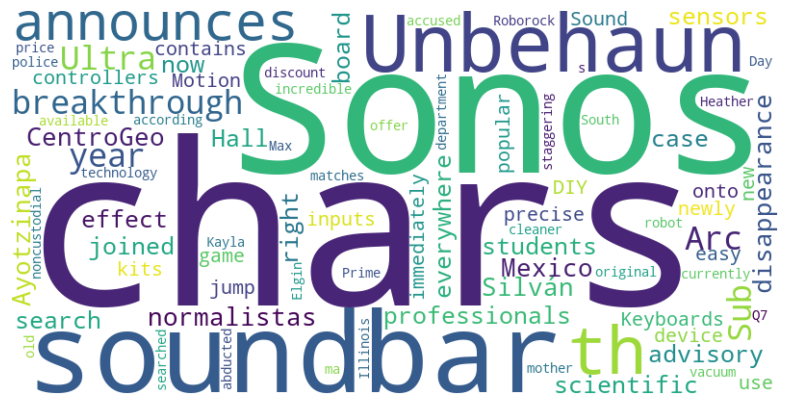

In [16]:
plt_wordcloud(processed_articles)

In [17]:
# Perform trend analysis
# trend_data = analyzer.trend_analysis(processed_articles["articles"], keywords=["technology", "AI"])
# analyzer.plot_trend_analysis(trend_data)


In [18]:
# Analyze and plot sentiment trends
# sentiment_trend_data = analyzer.sentiment_trend_analysis(processed_articles["articles"], sentiment_scores)
# analyzer.plot_sentiment_trend(sentiment_trend_data)